In [1]:
% ignore - internal setup
path('../scripts/', path)
set(0, 'DefaultLineLineWidth', 2)
set(0, 'DefaultAxesFontSize', 14);

# Monte Carlo

This is the simple Monte Carlo example you worked on in class.

Consider the following objective and constraint

\begin{align*}
f(x) &= x_1^2 + 2x_2^2 + 3x_3^2\\
c(x) &= x_1 + x_2 + x_3 \le 3.5
\end{align*}

At the point:

$$x = [1, 1, 1]$$

the standard deviation in $x$ is (normally distributed)

$$\sigma_x = [0.0, 0.06, 0.2]$$

Compute the following:
- Output statistics for $f$ (mean, standard deviation, histogram)
- Reliability of $c$

In [2]:
fun = @(x) x(1)^2 + 2*x(2)^2 + 3*x(3)^2;
con = @(x) x(1) + x(2) + x(3);

x = [1.0, 1.0, 1.0];
sigma = [0.00, 0.06, 0.2];

We will use randn, which gives us a random number k sampled from a normal distribution.  It is sampled from a unit normal with zero mean and a standard deviation of 1 so to translate to an arbitrary mean and standard deviation the random value will be
$$ x = \mu + k \sigma $$
If we sample enough times, we should get reliable statistics.  Let's put our sampling in a function because we don't yet know how many samples we need.

In [ ]:
function [muf, stdf, reliability, f, c] = stats(x, sigma, fun, con, n)

    f = zeros(n, 1);
    c = zeros(n, 1);

    % sample many times
    for i = 1:n
        x1 = x(1) + randn(1)*sigma(1);
        x2 = x(2) + randn(1)*sigma(2);
        x3 = x(3) + randn(1)*sigma(3);

        f(i) = fun([x1, x2, x3]);
        c(i) = con([x1, x2, x3]);
    end

    % mean
    muf = mean(f);

    % standard deviation
    stdf = std(f);

    % reliability
    reliability = nnz(c <= 3.5) / n;

end

Let's evaluate this function for different values of n (number of samples) to see how long it takes to converge.

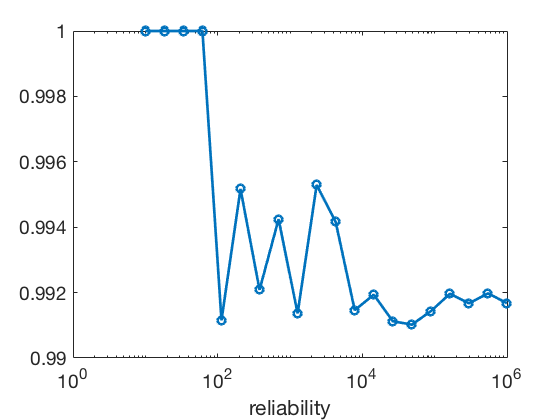

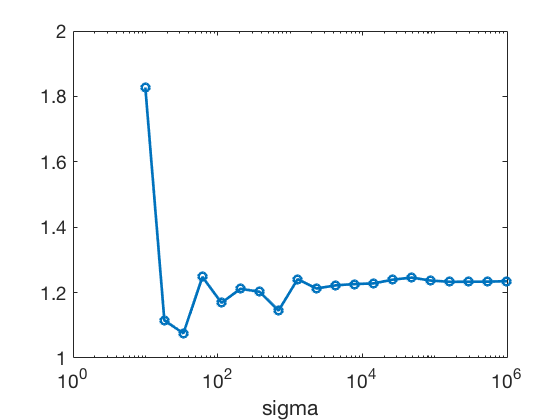

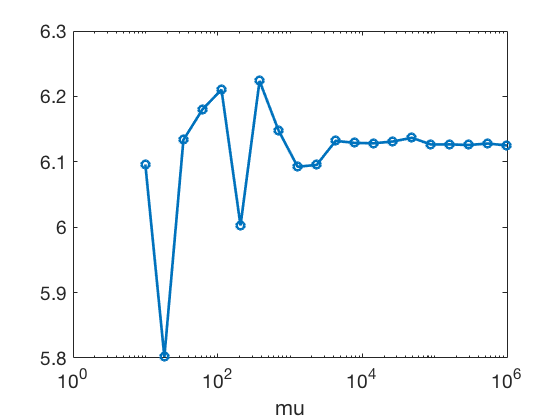

In [4]:
nvec = logspace(1, 6, 20);
muvec = zeros(20, 1);
stdvec = zeros(20, 1);
relvec = zeros(20, 1);

for i = 1:20
    [muvec(i), stdvec(i), relvec(i), ~, ~] = stats(x, sigma, fun, con, round(nvec(i)));
end
    
figure();
semilogx(nvec, muvec, '-o');
xlabel('mu');

figure();
semilogx(nvec, stdvec, '-o');
xlabel('sigma');

figure();
semilogx(nvec, relvec, '-o');
xlabel('reliability');

It looks like it takes about 100,000 ($10^5$) simulations for the statistics to converge.  Let's rerun that case and check our the histogram and statistics.


mu =

    6.1240


sd =

    1.2349


rel =

    0.9915



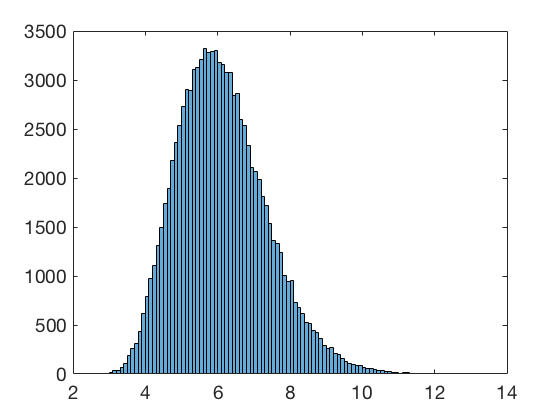

In [5]:
n = 1e5;
[mu, sd, rel, f, c] = stats(x, sigma, fun, con, n);
mu
sd
rel
figure()
histogram(f);

Notice that the distribution skews to the right even though all the inputs were symmetric normal distributions.  Because the function is nonlinear (quadratic in this case), symmetric inputs don't lead to symmetric outputs.  In particular squaring amplifies the effect of positive variations.

# Monte Carlo with LHS

In our discussion on surrogate-based optimization we will about Latin Hypercube Sampling (LHS).  Let's apply LHS to Monte Carlo to see if it speeds up convergence.


In [ ]:
function [muf, stdf, reliability, f, c] = stats(x, sigma, fun, con, n)

    f = zeros(n, 1);
    c = zeros(n, 1);

    % generate LHS points before hand
    lhs = lhsdesign(n, 2);  % n samples for 2 dimensions
    % there is no variation in sigma1 for this case.
    rand2 = icdf('Normal', lhs(:, 1), x(2), sigma(2));
    rand3 = icdf('Normal', lhs(:, 2), x(3), sigma(3));

    % can also use lhsnorm directly, but the above is more general for other distributions

    % sample many times
    for i = 1:n
        x1 = x(1);
        x2 = rand2(i);
        x3 = rand3(i);

        f(i) = fun([x1, x2, x3]);
        c(i) = con([x1, x2, x3]);
    end

    % mean
    muf = mean(f);

    % standard deviation
    stdf = std(f);

    % reliability
    reliability = nnz(c <= 3.5) / n;

end

In [ ]:
% run for different sizes of n

muLHS = zeros(20, 1);
stdLHS = zeros(20, 1);
relLHS = zeros(20, 1);

for i = 1:20
    [muLHS(i), stdLHS(i), relLHS(i), ~, ~] = statsLHS(x, sigma, fun, con, round(nvec(i)));
end


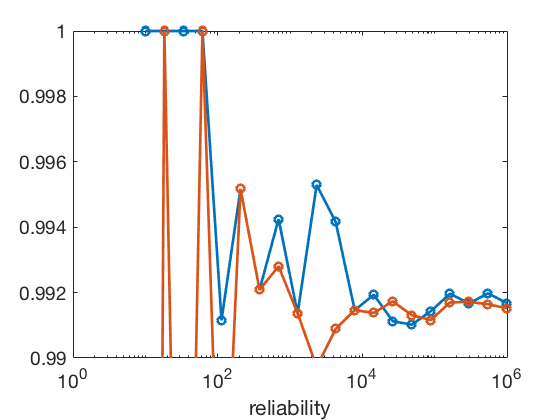

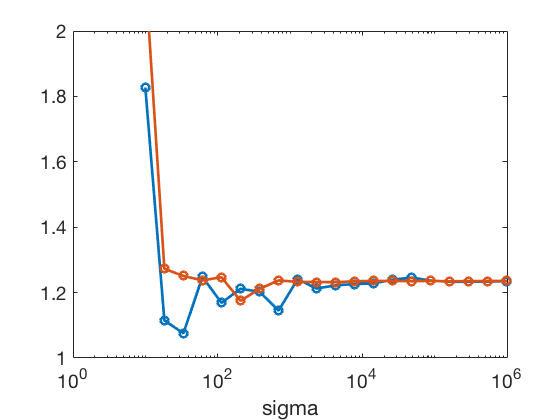

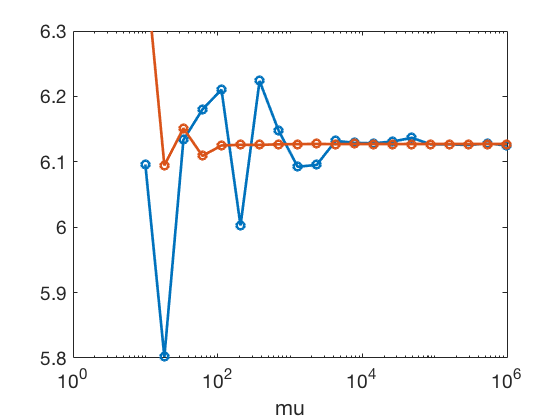

In [21]:
figure();
semilogx(nvec, muvec, '-o');
hold on;
semilogx(nvec, muLHS, '-o');
xlabel('mu');
ylim([5.8, 6.3])

figure(); 
semilogx(nvec, stdvec, '-o');
hold on;
semilogx(nvec, stdLHS, '-o');
xlabel('sigma');
ylim([1, 2])

figure(); 
semilogx(nvec, relvec, '-o');
hold on;
semilogx(nvec, relLHS, '-o');
xlabel('reliability');
ylim([0.99, 1])

Convergence is much faster!